In [3]:
from PIL import Image
import os, glob, numpy as np
from sklearn.model_selection import train_test_split

#1. 담홍설 2. 홍설 3. 담백설 4. 박태 5. 후태 6. 황태 

caltech_dir = "./multi_img_data"
categories = ["1", "2", "3", "4", "5", "6"]
nb_classes = len(categories)

image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
y = []

for idx, cat in enumerate(categories):
    
    #one-hot 돌리기.
    label = [0 for i in range(nb_classes)]
    label[idx] = 1

    image_dir = caltech_dir + "/" + cat
    files = glob.glob(image_dir+"/*.jpg")
    print(cat, " 파일 길이 : ", len(files))
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((image_w, image_h))
        data = np.asarray(img)

        X.append(data)
        y.append(label)

        if i % 700 == 0:
            print(cat, " : ", f)

X = np.array(X)
y = np.array(y)
#1 0 0 0 0 0이면 담홍설
#0 1 0 0 0 0이면 홍설
...


X_train, X_test, y_train, y_test = train_test_split(X, y)
xy = (X_train, X_test, y_train, y_test)
np.save("./numpy_data/multi_image_data.npy", xy)

print("ok", len(y))


1  파일 길이 :  4002
1  :  ./multi_img_data/1\1.jpg
1  :  ./multi_img_data/1\rotate0_541.jpg
1  :  ./multi_img_data/1\rotate1_3687.jpg
1  :  ./multi_img_data/1\rotate2_3248.jpg
1  :  ./multi_img_data/1\rotate3_2799.jpg
1  :  ./multi_img_data/1\rotate4_2340.jpg
2  파일 길이 :  4002
2  :  ./multi_img_data/2\2.JPG
2  :  ./multi_img_data/2\rotate0_541.jpg
2  :  ./multi_img_data/2\rotate1_3687.jpg
2  :  ./multi_img_data/2\rotate2_3248.jpg
2  :  ./multi_img_data/2\rotate3_2799.jpg
2  :  ./multi_img_data/2\rotate4_2340.jpg
3  파일 길이 :  4002
3  :  ./multi_img_data/3\3.jpg
3  :  ./multi_img_data/3\rotate0_541.jpg
3  :  ./multi_img_data/3\rotate1_3687.jpg
3  :  ./multi_img_data/3\rotate2_3248.jpg
3  :  ./multi_img_data/3\rotate3_2799.jpg
3  :  ./multi_img_data/3\rotate4_2340.jpg
4  파일 길이 :  4002
4  :  ./multi_img_data/4\4.jpg
4  :  ./multi_img_data/4\rotate0_541.jpg
4  :  ./multi_img_data/4\rotate1_3687.jpg
4  :  ./multi_img_data/4\rotate2_3248.jpg
4  :  ./multi_img_data/4\rotate3_2799.jpg
4  :  ./multi_

In [4]:
#numpy 데이터를 불러 학습, keras 사용

import os, glob, numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import keras.backend.tensorflow_backend as K

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

X_train, X_test, y_train, y_test = np.load('./numpy_data/multi_image_data.npy') 
#값을 불러옴
print(X_train.shape)
print(X_train.shape[0])

Using TensorFlow backend.


(18009, 64, 64, 3)
18009


In [5]:
#1. 담홍설 2. 홍설 3. 담백석 4. 박태 5. 후태 6. 황태
categories = ["담홍설", "홍설", "담백설", "박태", "후태", "황태"]
nb_classes = len(categories) # 클래스 개수 설정

#일반화
X_train = X_train.astype(float) / 255  
#정규화, 값의 폭이 크기 때문
X_test = X_test.astype(float) / 255

In [6]:
#데이터 전처리 끝, 훈련모델 생성
#컨볼루션 레이어 구축
#순서
#이미지->32 컨볼루션2D -> maxpooling -> dropout -> 64개 컨볼루션 2D -> maxpooling -> dropout -> 
#128개 컨볼루션 2D -> maxpooling 2D-> dropout -> Dense -> dropout ->dense
#망으로 구축

with K.tf_ops.device('/device:GPU:0'):
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model_dir = './model'
    
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    
    model_path = model_dir + '/multi_img_classification.model'
    checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=6)
    
    

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
__________

In [8]:

history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Train on 18009 samples, validate on 6003 samples
Epoch 1/10
18009/18009 [==============================] - 518s 29ms/step - loss: 0.0725 - acc: 0.9810 - val_loss: 8.0505e-06 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00001, saving model to ./model/multi_img_classification.model
Epoch 2/10
18009/18009 [==============================] - 483s 27ms/step - loss: 6.0286e-04 - acc: 0.9999 - val_loss: 1.2110e-07 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00001 to 0.00000, saving model to ./model/multi_img_classification.model
Epoch 3/10
18009/18009 [==============================] - 481s 27ms/step - loss: 4.7447e-04 - acc: 0.9999 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to ./model/multi_img_classification.model
Epoch 4/10
18009/18009 [==============================] - 484s 27ms/step - loss: 0.0030 - acc: 0.9990 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_loss did not improve 

In [9]:
print("정확도 : %.4f" % (model.evaluate(X_test, y_test)[1]))

6003/6003 [==============================] - 11s 2ms/step
정확도 : 1.0000


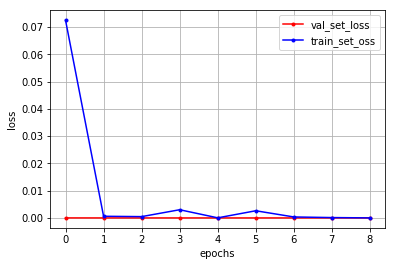

In [10]:
#loss 확인 그래프 생성
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))

plt.plot(x_len, y_vloss, marker='.', c='red', label='val_set_loss')
plt.plot(x_len, y_loss, marker='.', c='blue', label='train_set_oss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.show()

In [12]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

caltech_dir = "./multi_img_data/compare_imgae"
image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)

X = np.array(X)
model = load_model('./model/multi_img_classification.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0

#1. 담홍설 2. 홍설 3. 담백석 4. 박태 5. 후태 6. 황태
for i in prediction:
    pre_ans = i.argmax()  
    # 예측 레이블
    print(i)
    print(pre_ans)
    pre_ans_str = ''
    if pre_ans == 0: pre_ans_str = "담홍설"
    elif pre_ans == 1: pre_ans_str = "홍설"
    elif pre_ans == 2: pre_ans_str = "담백설"
    elif pre_ans == 2: pre_ans_str = "박태"
    elif pre_ans == 2: pre_ans_str = "후태"
    else: pre_ans_str = "황태"        
    if i[0] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[1] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"으로 추정됩니다.")
    if i[2] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[3] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[4] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    if i[5] >= 0.8: print("해당 "+filenames[cnt].split("\\")[1]+"이미지는 "+pre_ans_str+"로 추정됩니다.")
    
    cnt += 1

[0.000 0.000 0.000 0.000 0.000 1.000]
5
